# Importación de librerías y carga de datos

In [9]:
"""
Modulo de entrenamiento para diferentes pipelines de ML para el
entrenamiento utilizando los datasets creados. El flujo es capaz de 
generalizar en la mayoría de los casos y únicamente es necesario
realizar modificaciones en la ruta a los datos.

"""
import os
import pandas as pd 
import seaborn as sns                                                   
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, \
                                    cross_val_score, \
                                    learning_curve, \
                                    RandomizedSearchCV, \
                                    GridSearchCV
from sklearn.inspection import permutation_importance
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets, metrics
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from boruta import BorutaPy
from tpot import TPOTClassifier
import dataframe_image as dfi
import itertools
import joblib  
from sklearn.metrics import confusion_matrix, recall_score, precision_score


path=r'C:\Users\Daniel\OneDrive\Documentos\2024-1\Informatica medica\TRABAJO\Final_project_ML\Data'

In [16]:
data = pd.read_csv(os.path.join(path,'data.txt'),sep='\t')

In [17]:
data

,DESCRIPCION,Mes,Tipo Egreso (INTERNACION),Paciente Entidad Responsable Pago,Minutos (Camara - F3),Dx Principal Tipo,Paciente Edad,Paciente Sexo,Clasificacion 1 Triaje \r\nEnfermeria,Modalidad Atencion,...,M993,T68X,M431,D103,Q909,I671,C920,D539,L982,S530
0,1,2.634,0,48,26.633333,1,75.0,1,4,1,...,0,0,0,0,0,0,0,0,0,0
1,1,2.634,1,5,65.133333,0,61.0,1,3,1,...,0,0,0,0,0,0,0,0,0,0
2,1,2.634,1,65,82.050000,0,62.0,1,3,1,...,0,0,0,0,0,0,0,0,0,0
3,1,2.634,0,48,0.000000,0,78.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2.634,0,1,116.850000,0,73.0,0,3,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28782,1,1.634,1,53,70.583333,0,23.0,0,3,1,...,0,0,0,0,0,0,0,0,0,0
28783,1,1.634,1,48,42.500000,0,49.0,1,4,1,...,0,0,0,0,0,0,0,0,0,0
28784,1,1.634,1,65,50.133333,0,43.0,0,3,1,...,0,0,0,0,0,0,0,0,0,0
28785,1,1.634,1,18,40.900000,0,54.0,0,3,1,...,0,0,0,0,0,0,0,0,0,0


In [18]:
print(f'sujetos: {data.shape[0]} | caracteristicas: {data.shape[1]}')

sujetos: 28787 | caracteristicas: 2430


# Preprocesamiento

## Análisis exploratorio de datos

In [23]:
# Se elimina la columna, para ponerla al final

target = data.pop('Tipo Egreso (INTERNACION)')
data.insert(len(data.columns), target.name, target)

## Selección de caracteristicas

### Creación de datasets de entrenamiento y test

In [32]:
X = data.values[:,:-1].astype(float)
y = data.values[:,-1].astype(float)
print(X.shape)
print(y.shape)

(28787, 2429)
(28787,)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(                            
    X, # Valores de X
    y, # Valores de Y
    test_size=0.2, # Test de 20%
    random_state=1, # Semilla
    stratify=data.values[:,-1]) # que se mantenga la proporcion en la división

In [34]:
X_train

array([[ 0.   ,  1.617, 48.   , ...,  0.   ,  0.   ,  0.   ],
       [ 1.   ,  2.121,  5.   , ...,  0.   ,  0.   ,  0.   ],
       [ 1.   ,  2.994, 48.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 1.   ,  3.413, 65.   , ...,  0.   ,  0.   ,  0.   ],
       [ 1.   ,  2.442, 65.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  1.702, 48.   , ...,  0.   ,  0.   ,  0.   ]])

### Árboles de decisión (Grid Search)

In [37]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 30)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini',  'entropy', 'log_loss']

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion
               }

In [38]:
forestclf_grid = RandomForestClassifier()

rf_random = RandomizedSearchCV(
                              estimator=forestclf_grid,
                              param_distributions=random_grid,
                              n_iter=5,
                              cv=10,
                              verbose=2,
                              random_state=10,
                              n_jobs=-1
                              )

rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 165, 231, 296,
                                                         362, 427, 493, 558,
                                                         624, 689, 755, 820,
                                                         886, 951, 1017, 1082,
                                                         1148, 1213, 1279, 1344,
                                                         1410, 1475, 1541, 1606,
                                                         1672, 1737, 1803, 1868,
                                                         1934, 2000]},
                   random_state=10, verbose=2)

In [41]:
best_selected = rf_random.best_estimator_

In [42]:
best_selected

RandomForestClassifier(criterion='log_loss', max_depth=40, n_estimators=296)

In [43]:
GS_fitted = best_selected.fit(X_train, y_train)

In [44]:
predicted = GS_fitted.predict(X_test)

In [45]:
print(
    f"Classification report for classifier {GS_fitted}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
    )

Classification report for classifier RandomForestClassifier(criterion='log_loss', max_depth=40, n_estimators=296):
              precision    recall  f1-score   support

         0.0       0.80      0.74      0.77      2813
         1.0       0.77      0.82      0.79      2945

    accuracy                           0.78      5758
   macro avg       0.78      0.78      0.78      5758
weighted avg       0.78      0.78      0.78      5758




In [46]:
scores = cross_val_score(
                        estimator=GS_fitted,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )

In [47]:
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.78028658 0.78245766 0.77333912 0.76769431 0.78593139 0.77029961
 0.79027356 0.77768129 0.77854972 0.77845352]


In [48]:
print('\nCV accuracy: %.3f +/- %.3f' %
    (np.mean(scores), np.std(scores)))


CV accuracy: 0.778 +/- 0.007


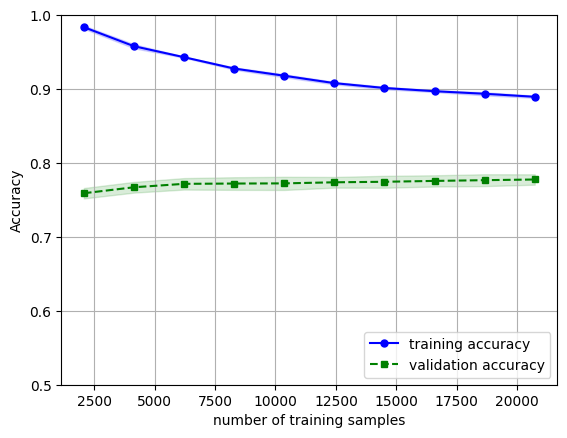

In [49]:
train_sizes, train_scores, test_scores = \
    learning_curve(
                  estimator=GS_fitted,
                  X=X_train,
                  y=y_train,
                  train_sizes=np.linspace(0.1, 1, 10),
                  cv=10,
                  n_jobs=-1
                  )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
        train_sizes,
        train_mean,
        color='blue',
        marker='o',
        markersize=5,
        label='training accuracy'
        )

plt.fill_between(
                train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue'
                )

plt.plot(
        train_sizes,
        test_mean,
        color='green',
        linestyle='--',
        marker='s',
        markersize=5,
        label='validation accuracy'
        )

plt.fill_between(
                train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,
                color='green'
                )

plt.grid()
plt.xlabel('number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.show()

### Árboles de decisión (Boruta).

In [ ]:
feat_selector = BorutaPy(
                        verbose=2,
                        estimator=best_selected,
                        max_iter=100,
                        random_state=10
                        )

In [ ]:
feat_selector.fit(X_train, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	544
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	544
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	544
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	544
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	2


BorutaPy(estimator=RandomForestClassifier(bootstrap=False, criterion='log_loss',
                                          max_depth=20, min_samples_leaf=2,
                                          min_samples_split=5,
                                          n_estimators=1000,
                                          random_state=RandomState(MT19937) at 0x2354076B140),
         random_state=RandomState(MT19937) at 0x2354076B140, verbose=2)

In [ ]:
selected_features = []
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", data.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
        selected_features.append(data.columns[i])


------Support and Ranking for each feature------
Passes the test:  power_C18_Gamma  - Ranking:  1
Passes the test:  power_C20_Gamma  - Ranking:  1
Passes the test:  sl_C18_Theta  - Ranking:  1


In [ ]:
X_transform = feat_selector.transform(X_train)

In [ ]:
boruta_fitted = best_selected.fit(X_transform, y_train)
modelos['Boruta'] = boruta_fitted

In [ ]:
selected_features = [data.columns.get_loc(c) for c in selected_features if c in data]
selected_features

[23, 31, 76]

In [ ]:
predicted = boruta_fitted.predict(X_test[:,selected_features])

In [ ]:
print(
    f"Classification report for classifier {boruta_fitted}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Classification report for classifier RandomForestClassifier(bootstrap=False, criterion='log_loss', max_depth=20,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=1000,
                       random_state=RandomState(MT19937) at 0x2354076B140):
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        20
         1.0       0.80      0.80      0.80        10

    accuracy                           0.87        30
   macro avg       0.85      0.85      0.85        30
weighted avg       0.87      0.87      0.87        30




In [ ]:
dataframe_metrics = metrics.classification_report(y_test, predicted, output_dict=True)
dataframe_metrics = pd.DataFrame(dataframe_metrics).T
dfi.export(dataframe_metrics, path_plot+'/'+'metrics_boruta.png')

C:\Program Files\Google\Chrome\Application\chrome.exe


In [ ]:
scores = cross_val_score(estimator=boruta_fitted,
                        X=X_transform,
                        y=y_train,
                        cv=10,
                        n_jobs=-1)

In [ ]:
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.75       0.91666667 0.83333333 0.91666667 0.66666667 0.83333333
 0.58333333 0.81818182 0.81818182 0.90909091]


In [ ]:
print('\nCV accuracy: %.3f +/- %.3f' %
    (np.mean(scores), np.std(scores)))


acc_per_feature.append(np.mean(scores))
std_per_feature.append(np.std(scores))


CV accuracy: 0.805 +/- 0.104


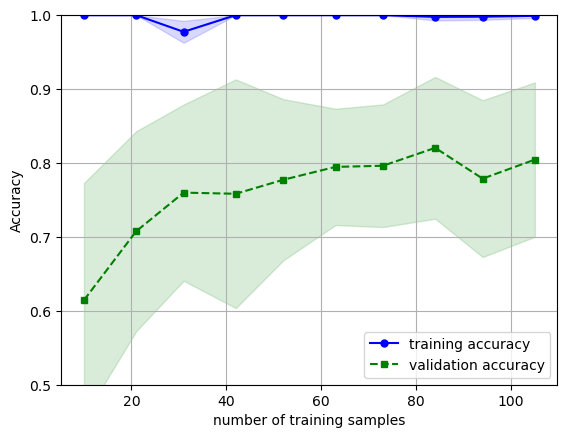

In [ ]:
train_sizes, train_scores, test_scores = \
    learning_curve(
                  estimator=boruta_fitted,
                  X=X_transform,
                  y=y_train,
                  train_sizes=np.linspace(0.1, 1, 10),
                  cv=10,
                  n_jobs=-1
                  )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
        train_sizes,
        train_mean,
        color='blue',
        marker='o',
        markersize=5,
        label='training accuracy'
        )

plt.fill_between(
                train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue'
                )

plt.plot(
        train_sizes,
        test_mean,
        color='green',
        linestyle='--',
        marker='s',
        markersize=5,
        label='validation accuracy'
        )

plt.fill_between(
                train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,
                color='green'
                )

plt.grid()
plt.xlabel('number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.savefig(path_plot+'/'+'validation_Boruta.png')
plt.show()

### Selección de caracteristicas con árboles de decisión

 1) power_C20_Gamma                0.035736
 2) power_C18_Gamma                0.016973
 3) power_C25_Gamma                0.015057
 4) cohfreq_C15_Theta              0.013651
 5) sl_C18_Delta                   0.013102
 6) sl_C18_Theta                   0.011932
 7) power_C14_Gamma                0.011365
 8) power_C24_Gamma                0.011303
 9) cohfreq_C18_Beta2              0.011143
10) crossfreq_C20_Mgamma_Gamma     0.010903
11) sl_C15_Beta3                   0.010826
12) sl_C25_Alpha-1                 0.009525
13) cohfreq_C18_Beta1              0.009279
14) cohfreq_C25_Beta1              0.009026
15) cohfreq_C15_Delta              0.008669
16) cohfreq_C25_Theta              0.008438
17) cohfreq_C23_Beta3              0.008158
18) sl_C15_Alpha-1                 0.007520
19) entropy_C15_Beta2              0.007488
20) power_C23_Gamma                0.007359
21) cohfreq_C18_Delta              0.007309
22) crossfreq_C14_Mbeta3_Beta3     0.007283
23) power_C14_Theta             

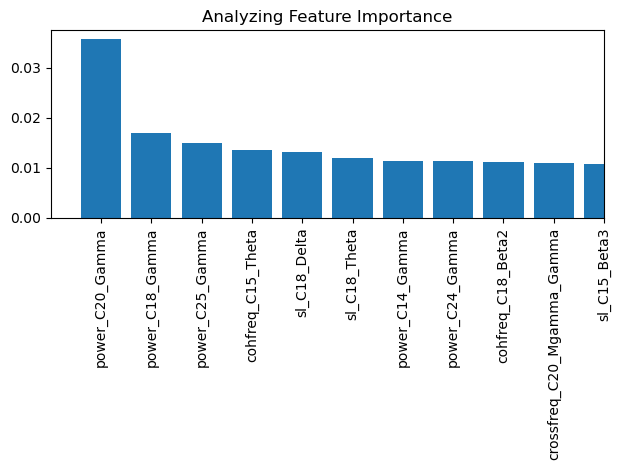

In [ ]:
nombres_columnas = data.columns[:-1]
best_selected.fit(X_train, y_train)
features_scores = best_selected.feature_importances_
features_scores
index = np.argsort(features_scores)[::-1]
sorted_names = []

for f in range(X_train.shape[1]):

    sorted_names.append(nombres_columnas[index[f]])
    print("%2d) %-*s %f" % (f + 1, 30,
                        nombres_columnas[index[f]],
                        features_scores[index[f]]))
    
plt.title('Analyzing Feature Importance')

plt.bar(range(X_train.shape[1]),
    features_scores[index],
    align='center')

plt.xticks(range(X_train.shape[1]),
    nombres_columnas[index],
    rotation=90)

plt.xlim([-1, 10])

plt.tight_layout()

plt.show()

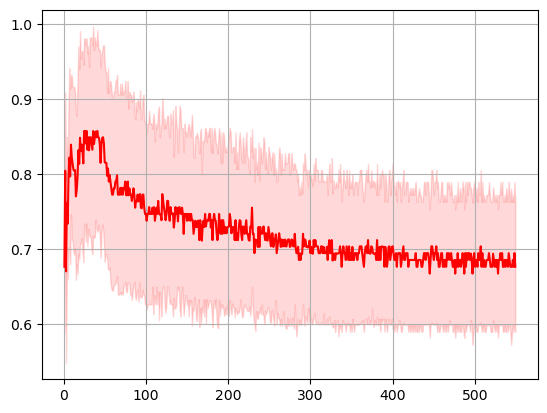

In [ ]:
for index, feature_name in enumerate(sorted_names,start=1):

    input_features_names = sorted_names[:index]
    input_features_index = [data.columns.get_loc(c) for c 
                      in input_features_names if c in data]
    feature_model = best_selected.fit(X_train[:, input_features_index], y_train)
    scores = cross_val_score(
                        estimator=feature_model,
                        X=X_train[:, input_features_index],
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )
    
  
    modelos['number_features_' + str(index)] = feature_model
    acc_per_feature.append(np.mean(scores))
    std_per_feature.append(np.std(scores))


#plt.plot(
#        range(1, len(sorted_names)),
#        acc_per_feature,
#        color='red'
#        ) 
#
#plt.fill_between(
#                range(1, len(sorted_names)),
#                np.array(acc_per_feature) + np.array(std_per_feature),
#                np.array(acc_per_feature) - np.array(std_per_feature),
#                alpha=0.15,
#                color='red'
#                )

plt.plot(
        range(1, len(acc_per_feature)+1),
        acc_per_feature,
        color='red'
        ) 

plt.fill_between(
                range(1, len(acc_per_feature)+1),
                np.array(acc_per_feature) + np.array(std_per_feature),
                np.array(acc_per_feature) - np.array(std_per_feature),
                alpha=0.15,
                color='red'
                )

plt.grid()
plt.savefig(path_plot+'/'+'features_plot_all.png')
plt.show()


In [ ]:
pos_model = np.argsort(acc_per_feature)[-1]
best_model = list(modelos.keys())[pos_model]
best_model

'number_features_26'

In [ ]:
joblib.dump(modelos[best_model], path_plot+'/'+'modelo_entrenado.pkl') # Guardo el modelo.

['C:\\Users\\veroh\\OneDrive - Universidad de Antioquia\\Verónica Henao Isaza\\Resultados\\graphics\\ML/G1_ic_/modelo_entrenado_ic.pkl']

In [ ]:
# Guardar mejore carateristicas
best_features=sorted_names[:pos_model]
mi_path = path_plot+'/'+'best_features.txt'
f = open(mi_path, 'w')

for i in best_features:
    f.write(i+'\n')
f.close()

In [ ]:
new_data = pd.DataFrame()
for i in range(0,len(data.columns)):
    for j in range(0,len(best_features)):
        if data.columns[i] == best_features[j]:
            new_data[best_features[j]] = data[best_features[j]]


In [ ]:
new_name = 'Data_complete_randomforest'+space+'_'+name
new_data.reset_index(drop=True).to_feather(rf'{path_excel}\{new_name}.feather')
            

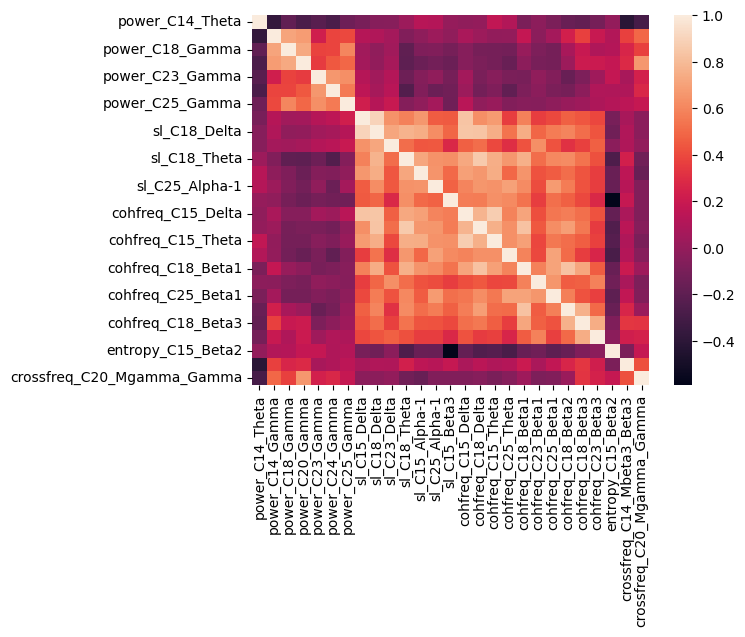

In [ ]:
sns.heatmap(new_data.corr())
plt.savefig(path_plot+'/'+'correlation_randomforest.png')

In [ ]:
selected_best_features = [new_data.columns.get_loc(c) for c in best_features if c in new_data]
selected_best_features

[3,
 2,
 1,
 10,
 5,
 8,
 6,
 18,
 13,
 21,
 16,
 20,
 14,
 12,
 23,
 26,
 11,
 24,
 4,
 7,
 17,
 19,
 25,
 15,
 0,
 9,
 22]

In [ ]:
best_features

['power_C20_Gamma',
 'power_C18_Gamma',
 'power_C14_Gamma',
 'sl_C18_Theta',
 'power_C24_Gamma',
 'sl_C18_Delta',
 'power_C25_Gamma',
 'cohfreq_C18_Beta1',
 'sl_C15_Beta3',
 'cohfreq_C18_Beta2',
 'cohfreq_C15_Theta',
 'cohfreq_C25_Beta1',
 'cohfreq_C15_Delta',
 'sl_C25_Alpha-1',
 'cohfreq_C23_Beta3',
 'crossfreq_C20_Mgamma_Gamma',
 'sl_C15_Alpha-1',
 'entropy_C15_Beta2',
 'power_C23_Gamma',
 'sl_C15_Delta',
 'cohfreq_C25_Theta',
 'cohfreq_C23_Beta1',
 'crossfreq_C14_Mbeta3_Beta3',
 'cohfreq_C18_Delta',
 'power_C14_Theta',
 'sl_C23_Delta',
 'cohfreq_C18_Beta3']

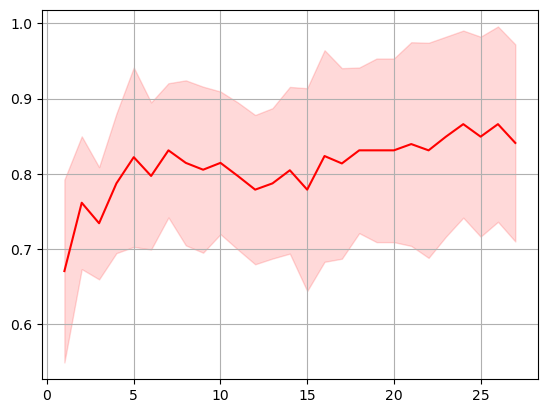

In [ ]:
acc = []
std = []
m=[]
for index, feature_name in enumerate(best_features,start=1):

    input_features_best = best_features[:index]
    input_best_index = [data.columns.get_loc(c) for c 
                      in input_features_best if c in data]
    fbest_model = best_selected.fit(X_train[:, input_best_index], y_train)
    scores_best = cross_val_score(
                        estimator=fbest_model,
                        X=X_train[:, input_best_index],
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )
    
  
    #m['number_features_BEST' + str(index)] = fbest_model
    acc.append(np.mean(scores_best))
    std.append(np.std(scores_best))

plt.plot(
        range(1, len(acc)+1),
        acc,
        color='red'
        ) 

plt.fill_between(
                range(1, len(acc)+1),
                np.array(acc) + np.array(std),
                np.array(acc) - np.array(std),
                alpha=0.15,
                color='red'
                )

plt.grid()
plt.savefig(path_plot+'/'+'features_plot_best.png')
plt.show()

In [ ]:
print(acc[-1])
print(std[-1])

0.8409090909090908
0.13108468862642386


In [ ]:
predicted = fbest_model.predict(X_test[:,input_best_index])
classes_x=(predicted >= 0.5).astype(int)
computerprecision(y_test,classes_x)

Precision:  0.8 
 Recall:  0.8 
 F1-score: 0.8000000000000002


Confusion matrix, without normalization
[[18  2]
 [ 2  8]]


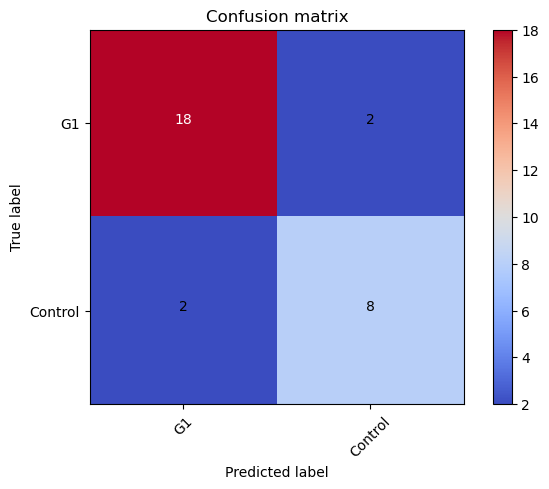

In [ ]:
class_names=['G1','Control']
cm_test = confusion_matrix(y_test,classes_x)
plot_confusion_matrix(path_plot,cm_test,classes=class_names,title='Confusion matrix')

c:\Users\veroh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


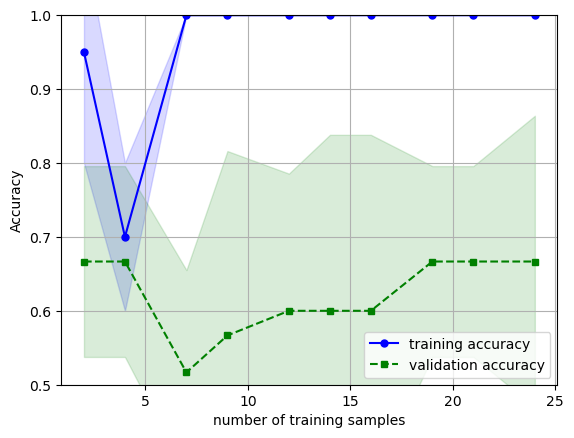

In [ ]:
train_sizes, train_scores, test_scores = \
    learning_curve(
                  estimator=modelos[best_model],
                  X=X_test[selected_best_features],## Revisar
                  y=y_train[selected_best_features],
                  train_sizes=np.linspace(0.1, 1, 10),
                  cv=10,
                  n_jobs=-1
                  )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)# test_score
test_std = np.std(test_scores, axis=1)

plt.plot(
        train_sizes,
        train_mean,
        color='blue',
        marker='o',
        markersize=5,
        label='training accuracy'
        )

plt.fill_between(
                train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue'
                )

plt.plot(
        train_sizes,
        test_mean,
        color='green',
        linestyle='--',
        marker='s',
        markersize=5,
        label='validation accuracy'
        )

plt.fill_between(
                train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,
                color='green'
                )

plt.grid()
plt.xlabel('number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.savefig(path_plot+'/'+'validation_randomforest.png')
plt.show()

### SVM (Grid Search)

In [ ]:
svm_param_grid = {'C': list(np.logspace(-1, 4, 6)), 
                 'gamma': list(np.logspace(-3, 2, 6)) + ['Auto'] + ['scale'],
                 'kernel': ['rbf', 'poly']} 

svc = SVC()
svc_clf = GridSearchCV(
                      svc,
                      svm_param_grid,
                      n_jobs=-1,
                      cv=10
                      )

svm_best_clf = svc_clf.fit(X_train, y_train)
best_model = svm_best_clf.best_estimator_

c:\Users\veroh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\veroh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\veroh\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 180, in fit
    self._validate_params()
  File "c:\Users\veroh\anaconda3\lib\site-packages\sklearn\base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\veroh\anaconda3\lib\site-packages\sk

In [ ]:
best_model.fit(X_train, y_train)

SVC(C=0.1, gamma=0.001)

In [ ]:
predicted = best_model.predict(X_test)

In [ ]:
print(
    f"Classification report for classifier {best_model}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
    )

Classification report for classifier SVC(C=0.1, gamma=0.001):
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80        20
         1.0       0.00      0.00      0.00        10

    accuracy                           0.67        30
   macro avg       0.33      0.50      0.40        30
weighted avg       0.44      0.67      0.53        30




c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
dataframe_metrics = metrics.classification_report(y_test, predicted, output_dict=True)
dataframe_metrics = pd.DataFrame(dataframe_metrics).T
dfi.export(dataframe_metrics, path_plot+'/'+'metrics_SVM.png')

c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Program Files\Google\Chrome\Application\chrome.exe
